We can make a slight improvement to the **Hunt** part of the hunt and target algorithm using parity.


Because the minimum length of a ship is two units long, then we
don't need to random search every location on the board. Even
the shortest ship has to straddle two adjacent squares.

A mathematical term to describe this is **Parity**. This is just a
fancy word of describing if the square would contain an odd or
even number if labelled sequentially from 1 to 100.

The blue squares on the grid are even parity and the white
squares odd parity.

![Parity ](https://i.imgur.com/g5zbP0t.png)

We can instruct our **Hunt** algorithm to only randomly fire into
unknown locations with even parity. Even if we only ever fire at
blue locations, we will at least hit every ship — it's impossible to
place any ship so that it does not touch at least one blue
square.

Once a target as been hit, and Target mode is activated, the
'parity' restriction is lifted enabling all potential targets to be
investigated. If the algorithm returns to Hunt mode, again, the
parity filter is enabled.

Some readers will have realised that, once we've sunk
the two unit destroyer, we can change the parity restriction to a
larger spacing, but we're not going to implement that bit.

In [1]:
from Gameboard import *
from Random import *
from collections import deque

In [2]:
%%capture
board = Gameboard()
random = Random()

In [3]:
# everything is the same as in hunt and target strategy,
# except we manually change the available locations list (in Random class) 
# so that only even indexed elements remain
shots = []
accuracies = []

for i in range(100000):
    # get ready
    queue = deque()
    visited_locations = set()
    mode = 'hunt'
    board.hide_ship(*random.generate_ship_locations())

    # change available locations list to checkerboard pattern as in picture above
    new_available_locations = []
    for i in range(0, len(random.available_locations)):
        curr_row = i // Gameboard.nrows
        if curr_row % 2 == 0 and i % 2 == 0:
            new_available_locations.append(random.available_locations[i])
        elif curr_row % 2 != 0 and i % 2 != 0:
            new_available_locations.append(random.available_locations[i])
    random.available_locations = new_available_locations

    while True:
        # run single game
        if mode == 'hunt':
            random_loc = random.choose()
            visited_locations.add(random_loc)
            if board.shoot(random_loc):
                mode = 'target'
                for loc in board.neighbours(random_loc):
                    if loc not in visited_locations:
                        queue.append(loc)
        elif mode == 'target':
            target_loc = queue.popleft()
            if target_loc not in visited_locations:
                visited_locations.add(target_loc)
                if target_loc in random.available_locations:
                    random.make_unavailable(target_loc)
                if board.shoot(target_loc):
                    for loc in board.neighbours(target_loc):
                        if loc not in visited_locations:
                            queue.append(loc)
            if len(queue) == 0:
                mode = 'hunt'

        if board.is_game_over():
            break

    # capture statistics
    shots.append(board.get_shot_count())
    accuracies.append(board.get_accuracy())    

    # clean up
    board.clear()
    random.reset_available_locations()

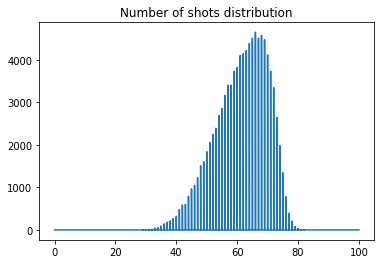

In [4]:
hist = np.histogram(shots, bins=len(shots), range=(0, 100))
plt.plot(hist[1][:-1], hist[0])
plt.title('Number of shots distribution')
plt.show()

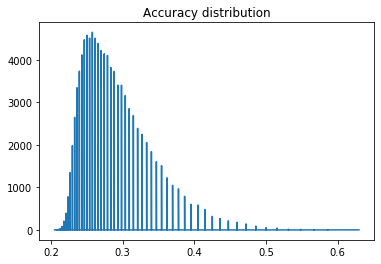

In [5]:
hist = np.histogram(accuracies, bins=len(accuracies))
plt.plot(hist[1][:-1], hist[0])
plt.title('Accuracy distribution')
plt.show()

The parity algorithm gives improvment over the entire range, but the incremental
gain is small. The biggest drain on shots is the unecessary walking around the edges of targets. Using the parity filter in Hunt mode has
reduced the shot count, but once the algorithm gets into Target mode, it is just as inefficient as it was. To make futher improvements in
strategy, it is this area we need to focus our attention.